In [1]:

import sys
sys.path.insert(0, '../scripts/')
from load_modify_sample_utils import load_model, get_objective_functions, get_reaction_bounds, modify_model, sample_gapsplit, plot_grid_95_reactions
from load_modify_sample_utils import sample_dingo, sample_optgp, sampling_statistics
from correlations_utils import correlated_reactions, split_forward_reverse
from graphs_utils import construct_graph, plot_graph, compare_betweenness_centralities


/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/touliopoulos/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:

ec_cobra_model, ec_cobra_reactions, ec_dingo_model, ec_dingo_reactions = load_model("../ext_data/models/e_coli_core.xml")

objective_functions = get_objective_functions(ec_cobra_model)
print(objective_functions)

default_reaction_bounds = get_reaction_bounds(ec_cobra_model)
print(default_reaction_bounds)


Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
['BIOMASS_Ecoli_core_w_GAM']
{'PFK': (0.0, 1000.0), 'PFL': (0.0, 1000.0), 'PGI': (-1000.0, 1000.0), 'PGK': (-1000.0, 1000.0), 'PGL': (0.0, 1000.0), 'ACALD': (-1000.0, 1000.0), 'AKGt2r': (-1000.0, 1000.0), 'PGM': (-1000.0, 1000.0), 'PIt2r': (-1000.0, 1000.0), 'ALCD2x': (-1000.0, 1000.0), 'ACALDt': (-1000.0, 1000.0), 'ACKr': (-1000.0, 1000.0), 'PPC': (0.0, 1000.0), 'ACONTa': (-1000.0, 1000.0), 'ACONTb': (-1000.0, 1000.0), 'ATPM': (8.39, 1000.0), 'PPCK': (0.0, 1000.0), 'ACt2r': (-1000.0, 1000.0), 'PPS': (0.0, 1000.0), 'ADK1': (-1000.0, 1000.0), 'AKGDH': (0.0, 1000.0), 'ATPS4r': (-1000.0, 1000.0), 'PTAr': (-1000.0, 1000.0), 'PYK': (0.0, 1000.0), 'BIOMASS_Ecoli_core_w_GAM': (0.0, 1000.0), 'PYRt2': (-1000.0, 1000.0), 'CO2t': (-1000.0, 1000.0), 'RPE': (-1000.0, 1000.0), 'CS': (0.0, 1000.0), 'RPI': (-1000.0, 1000.0), 'SUCCt2_2': (0.0, 1000.0), 'CYTBD': (0.0, 1000.

In [3]:

ec_cobra_model_condition_1, ec_dingo_model_condition_1 = modify_model(ec_cobra_model, objective_function="BIOMASS_Ecoli_core_w_GAM", optimal_percentage=100)
ec_cobra_model_condition_2, ec_dingo_model_condition_2 = modify_model(ec_cobra_model, objective_function="BIOMASS_Ecoli_core_w_GAM", optimal_percentage=0)


samples_optgp_condition_1 = sample_optgp(ec_cobra_model_condition_1, n_samples = 3000, thinning=100, reaction_in_rows = True)
samples_optgp_condition_2 = sample_optgp(ec_cobra_model_condition_2, n_samples = 3000, thinning=100, reaction_in_rows = True)


Read LP format model from file /tmp/tmplo_pk9fj.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmpxbj8r_yg.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmpijhah2l5.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmptjq1si12.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


In [25]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.cluster import SpectralBiclustering


n_reactions = len(ec_dingo_reactions)
n_samples = samples_optgp_condition_1.shape[1]


flux_df = pd.DataFrame(
    data=samples_optgp_condition_1,
    index=[f"{i}" for i in range(n_reactions)],
    columns=[f"S{i}" for i in range(n_samples)]
)

# --- Perform biclustering ---
n_biclusters = 10  # you can tune this
model = SpectralBiclustering(n_clusters=n_biclusters, method='log', random_state=0)
model.fit(flux_df.values)

# --- Reorder matrix to show biclusters ---
flux_reordered = flux_df.iloc[model.row_labels_.argsort(), model.column_labels_.argsort()]


# --- Optional: Print cluster assignments ---
reaction_clusters = pd.Series(model.row_labels_, index=flux_df.index, name="Reaction Cluster")
sample_clusters = pd.Series(model.column_labels_, index=flux_df.columns, name="Sample Cluster")

print("\nReaction Clusters:")
print(reaction_clusters.value_counts().sort_index())

print("\nSample Clusters:")
print(sample_clusters.value_counts().sort_index())





Reaction Clusters:
Reaction Cluster
0    55
1     2
2     1
3     1
4     2
5     2
6    15
7     1
8     1
9    15
Name: count, dtype: int64

Sample Clusters:
Sample Cluster
0    323
1    324
2    310
3    287
4    274
5    315
6    320
7    290
8    288
9    269
Name: count, dtype: int64


In [26]:
for cluster_id in sorted(reaction_clusters.unique()):
    print(f"\nReactions in Cluster {cluster_id}:")
    reactions_in_cluster = reaction_clusters[reaction_clusters == cluster_id].index.tolist()
    for index in reactions_in_cluster:
        index = int(index)
        print(ec_dingo_reactions[index], end=" ")
    print("\n")
        


Reactions in Cluster 0:
PGK ACALD AKGt2r PGM PIt2r ALCD2x ACALDt ACKr ACt2r PTAr BIOMASS_Ecoli_core_w_GAM PYRt2 CO2t RPE RPI D_LACt2 ENO ETOHt2r TALA TKT1 TKT2 TPI EX_ac_e EX_acald_e EX_akg_e EX_co2_e EX_etoh_e EX_fru_e EX_fum_e EX_glc__D_e EX_gln__L_e EX_glu__L_e EX_h2o_e EX_lac__D_e EX_mal__L_e EX_nh4_e EX_pi_e EX_pyr_e EX_succ_e FBA FRUpts2 FUMt2_2 GAPD GLCpts GLNS GLNabc GLUDy GLUN GLUSy GLUt2r H2Ot LDH_D MALt2_2 ME1 NH4t 


Reactions in Cluster 1:
SUCDi FRD7 


Reactions in Cluster 2:
FORt 


Reactions in Cluster 3:
FORt2 


Reactions in Cluster 4:
ATPS4r THD2 


Reactions in Cluster 5:
PYK MDH 


Reactions in Cluster 6:
PFK PGL ATPM PPCK PPS ADK1 AKGDH SUCCt2_2 SUCCt3 EX_o2_e FBP G6PDH2r GND ICDHyr ME2 


Reactions in Cluster 7:
PPC 


Reactions in Cluster 8:
NADTRHD 


Reactions in Cluster 9:
PFL PGI ACONTa ACONTb CS CYTBD SUCOAS EX_for_e EX_h_e FUM ICL MALS NADH16 O2t PDH 



In [30]:

from correlations_utils import correlated_reactions


extended_steady_states_condition_1, extended_reactions_conditions_1 = split_forward_reverse(samples_optgp_condition_1, reactions=ec_dingo_reactions)


(linear_correlation_matrix_1, 
#non_linear_correlation_matrix_1, 
#mixed_correlation_matrix_1, 
correlations_dictionary_1) = correlated_reactions(
        steady_states = extended_steady_states_condition_1,
        boolean_sharing_metabolites_matrix=None,
        reactions=extended_reactions_conditions_1, 
        linear_corr_cutoff = 0.3, 
        indicator_cutoff = 1.2,
        jensenshannon_cutoff = 0.1,
        std_cutoff= 1e-2,
        include_non_linear = False, 
        cells = 4, 
        cop_coeff = 0.2, 
        lower_triangle = False, 
        verbose = True)



/home/touliopoulos/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/touliopoulos/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/tmp/ipykernel_150599/742000278.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


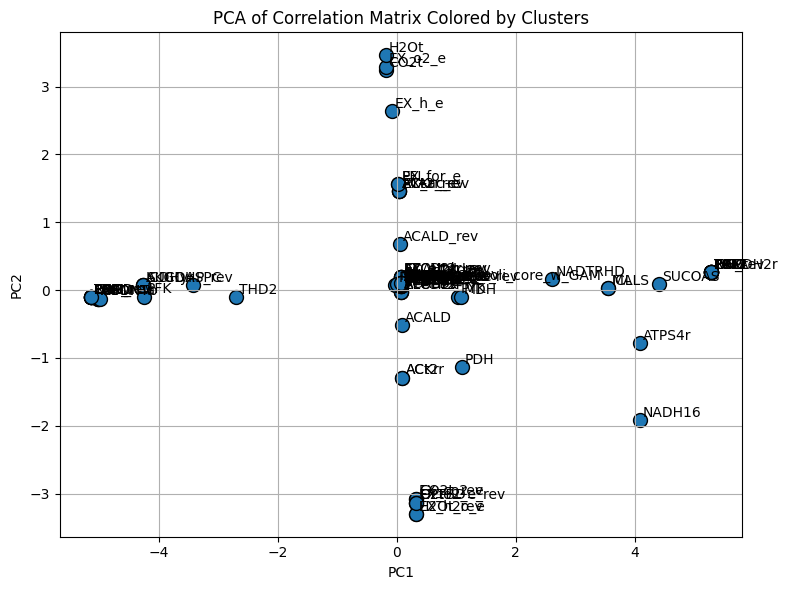

In [39]:

from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_result = pca.fit_transform(linear_correlation_matrix_1)


plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_result[:, 0], pca_result[:, 1],
    cmap='viridis', s=100, edgecolors='k'
)
plt.title('PCA of Correlation Matrix Colored by Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

num_features = linear_correlation_matrix_1.shape[0]  # assuming it's square
for i in range(num_features):
    plt.text(pca_result[i, 0] + 0.05, pca_result[i, 1] + 0.05, f"{extended_reactions_conditions_1[i]}")
    
plt.grid(True)
plt.tight_layout()
plt.show()